## **Import Libraries**

In [143]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

## **Load Dataset**

In [144]:
example_pats = pd.read_csv('../data/med_events.csv')
example_pats.head(15)

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1974,01/13/2022,2,medA,60
1,1542,09/05/2023,1,medA,30
2,1292,07/04/2023,1,medB,90
3,1787,08/04/2023,2,medB,60
4,1837,11/30/2022,2,medA,30
5,1859,08/11/2023,1,medA,90
6,1059,11/16/2022,2,medB,60
7,1522,08/17/2022,2,medB,60
8,1370,06/14/2022,1,medA,30
9,1039,02/14/2023,2,medA,60


## **Rename Columns**

In [145]:
tidy = example_pats
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]


## **Convert Date Column to Datetime and sort values**

In [146]:
tidy['eksd'] = pd.to_datetime(tidy['eksd'])
tidy = tidy.sort_values(['pnr', 'eksd'])
tidy.head()

,pnr,eksd,perday,ATC,dur_original
442,1010,2022-02-12,1,medB,30
409,1010,2022-04-27,2,medB,90
484,1010,2022-05-23,1,medA,90
357,1010,2022-08-20,2,medA,30
215,1010,2022-09-03,2,medA,30


## **Exploratory Data Analysis**

### Inspect the dataset structure, summary statistics, and missing values.  

In [147]:
print(tidy.info())
print(tidy.describe())
print(tidy.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 442 to 533
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pnr           1080 non-null   int64         
 1   eksd          1080 non-null   datetime64[ns]
 2   perday        1080 non-null   int64         
 3   ATC           1080 non-null   object        
 4   dur_original  1080 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 50.6+ KB
None
               pnr                 eksd       perday  dur_original
count  1080.000000                 1080  1080.000000   1080.000000
mean   1483.462037  2022-12-28 16:00:00     1.506481     60.055556
min    1010.000000  2022-01-01 00:00:00     1.000000     30.000000
25%    1261.000000  2022-07-03 00:00:00     1.000000     30.000000
50%    1521.000000  2023-01-01 00:00:00     2.000000     60.000000
75%    1697.500000  2023-06-20 00:00:00     2.000000     90.000000
max 

### Distribution of Medication Duration  

Visualizing the distribution of `dur_original` to understand its spread and density.  

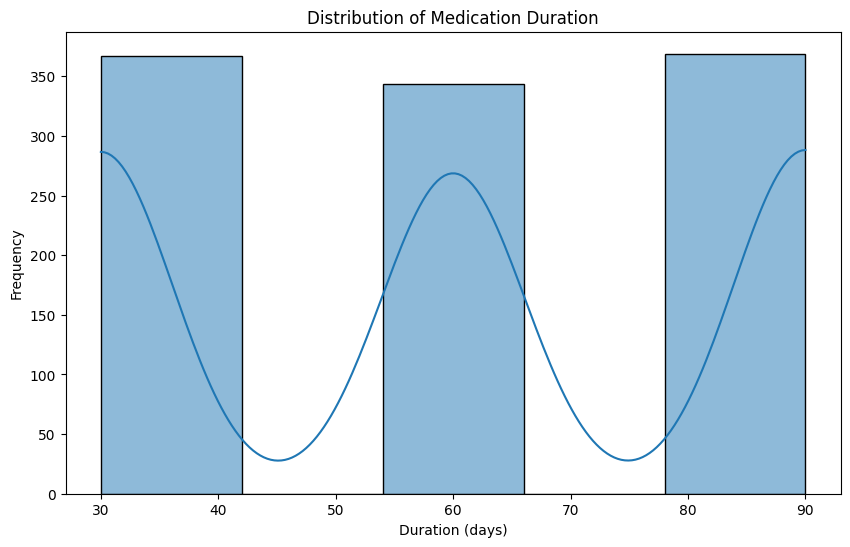

In [148]:
plt.figure(figsize=(10, 6))
sns.histplot(tidy['dur_original'], bins=5, kde=True)
plt.title('Distribution of Medication Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

### Prescription Distribution by Medication Type  

Visualizing the count of prescriptions for each medication category (`ATC`).  

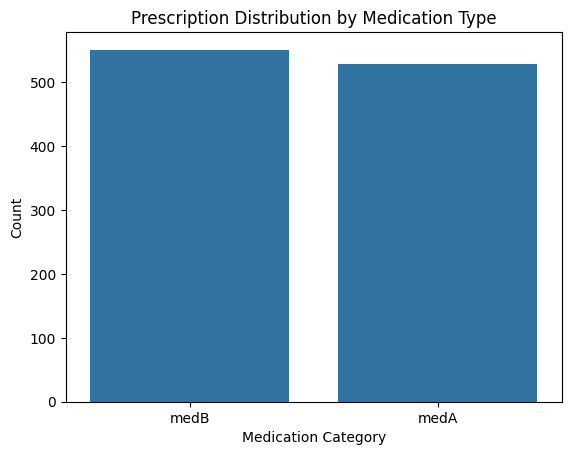

In [149]:
sns.countplot(x='ATC', data=tidy)
plt.title('Prescription Distribution by Medication Type')
plt.xlabel('Medication Category')
plt.ylabel('Count')
plt.show()

## **Sessa Empirical Estimator (K-Means)**

In [150]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def See(arg1, tidy):
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data (Fixed)
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove NAs and sample one row per patient (Fixed)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').sample(1, random_state=123)

    # Select columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - 
                                    drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF (needed for clustering)
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain 80% of ECDF (needed for clustering)
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Find optimal number of clusters
    silhouette_scores = []
    K = range(2, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        kmeans.fit(dfper[['x']])
        score = silhouette_score(dfper[['x']], kmeans.labels_)
        silhouette_scores.append(score)
    
    max_cluster = K[np.argmax(silhouette_scores)]
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
    
    # Calculate cluster statistics (Fixed log issue)
    cluster_stats = pd.DataFrame()
    for cluster in range(max_cluster):
        cluster_data = np.log(dfper[dfper['cluster'] == cluster]['x'] + 1e-9)  # Avoid log(0)
        stats_dict = {
            'Cluster': cluster,
            'Minimum': np.exp(cluster_data.min()),
            'Maximum': np.exp(cluster_data.max()),
            'Median': np.exp(cluster_data.median())
        }
        cluster_stats = pd.concat([cluster_stats, pd.DataFrame([stats_dict])], 
                                  ignore_index=True)
    
    # Process results
    results = pd.merge(
        drug_see_p1,
        cluster_stats,
        how='cross'
    )
    
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    results = results.dropna(subset=['Final_cluster'])
    
    # Get most frequent cluster
    t1 = results['Cluster'].mode().iloc[0]
    t1_merged = results[results['Cluster'] == t1][['Cluster', 'pnr', 'Median']].iloc[0]
    
    # Final processing
    drug_see_p1 = pd.merge(drug_see_p1, results[['pnr', 'Median', 'Cluster']], 
                          on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna('0')
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - 
                               drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Final merge and processing
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
    
    return drug_see_p0


## **Sessa Empirical Estimator (DBScan)**

In [151]:
def See_dbscan(arg1, tidy):
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data
    drug_see_p1 = (drug_see_p1
                   .sort_values(['pnr', 'eksd'])
                   .groupby('pnr')
                   .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
                   .reset_index(drop=True))
    
    # Remove NAs and sample one row per patient
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(
        lambda x: x.iloc[np.random.randint(len(x))]
    ).reset_index(drop=True)
    
    # Select columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - 
                                    drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain 80% of ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plotting ECDF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(dfper['x'], dfper['y'])
    ax1.set_title('80% ECDF')
    ax2.plot(x, y)
    ax2.set_title('100% ECDF')
    plt.show()
    
    # Density plot of log intervals
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= dfper['x'].max()]
    kde = gaussian_kde(np.log(drug_see_p2['event.interval'].astype(float)))
    x_range = np.linspace(np.log(drug_see_p2['event.interval'].min()), 
                         np.log(drug_see_p2['event.interval'].max()), 100)
    plt.figure()
    plt.plot(x_range, kde(x_range))
    plt.title('Log(event interval)')
    plt.show()
    
    # Prepare data for DBSCAN
    X = dfper[['x']].values
    X_scaled = StandardScaler().fit_transform(X)
    
    # DBSCAN clustering
    # eps and min_samples can be adjusted based on your data
    dbscan = DBSCAN(eps=0.3, min_samples=5)
    dfper['cluster'] = dbscan.fit_predict(X_scaled)
    
    # Plot clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clusters')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')
    plt.show()
    
    # Calculate cluster statistics
    cluster_stats = []
    for cluster in sorted(dfper['cluster'].unique()):
        cluster_data = np.log(dfper[dfper['cluster'] == cluster]['x'])
        if len(cluster_data) > 0:  # Check if cluster has data
            stats_dict = {
                'Cluster': cluster,
                'Minimum': np.exp(cluster_data.min()),
                'Maximum': np.exp(cluster_data.max()),
                'Median': np.exp(cluster_data.median())
            }
            cluster_stats.append(stats_dict)
    
    cluster_stats = pd.DataFrame(cluster_stats)
    
    # Handle noise points (cluster = -1) separately
    if -1 in dfper['cluster'].unique():
        noise_data = dfper[dfper['cluster'] == -1]
        print(f"Number of noise points: {len(noise_data)}")
    
    # Process results
    results = pd.merge(
        drug_see_p1,
        cluster_stats,
        how='cross'
    )
    
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    results = results.dropna(subset=['Final_cluster'])
    
    # Get most frequent non-noise cluster
    valid_clusters = results[results['Cluster'] != -1]['Cluster']
    if len(valid_clusters) > 0:
        t1 = valid_clusters.mode().iloc[0]
        t1_merged = results[results['Cluster'] == t1][['Cluster', 'pnr', 'Median']].iloc[0]
    else:
        # Handle case where all points might be noise
        t1_merged = results[['Cluster', 'pnr', 'Median']].iloc[0]
    
    # Final processing
    drug_see_p1 = pd.merge(drug_see_p1, results[['pnr', 'Median', 'Cluster']], 
                          on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna(-1)  # Use -1 for unassigned
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - 
                               drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Final merge and processing
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(-1)
    
    return drug_see_p0

## **Assumption Testing: Prescription Interval Analysis**

This function examines prescription patterns over time using boxplots.

In [152]:
def see_assumption(arg1):
    """
    Analyze prescription patterns over time with boxplots
    
    Parameters:
    arg1 (pd.DataFrame): DataFrame containing prescription data
    
    Returns:
    matplotlib.figure.Figure: Boxplot visualization
    """
    # Sort and create lagged column
    arg1 = (arg1.sort_values(['pnr', 'eksd'])
            .groupby('pnr')
            .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
            .reset_index(drop=True))
    
    # Create sequence numbers
    drug_see2 = (arg1.groupby('pnr')
                 .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))
                 .reset_index(drop=True))
    
    # Filter for p_number >= 2
    drug_see2 = drug_see2[drug_see2['p_number'] >= 2]
    
    # Select required columns
    drug_see2 = drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate duration
    drug_see2['Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days
    
    # Convert p_number to string for plotting
    drug_see2['p_number'] = drug_see2['p_number'].astype(str)
    
    # Calculate median of medians
    medians_of_medians = (drug_see2.groupby('pnr')['Duration']
                         .median()
                         .median())
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Create boxplot using seaborn
    sns.boxplot(x='p_number', y='Duration', data=drug_see2)
    
    # Add horizontal line for median of medians
    plt.axhline(y=medians_of_medians, color='red', linestyle='--', 
                label=f'Median of medians: {medians_of_medians:.1f}')
    
    # Customize plot
    plt.title('Duration Between Prescriptions by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

## Visualization Function

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_event_intervals_see(data):
    """Helper function to compute event intervals using same logic as See()"""
    df = data.copy()
    # Sort by patient and date
    df = df.sort_values(['pnr', 'eksd'])
    # Create previous date column
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    # Remove rows with no previous date
    df = df.dropna(subset=['prev_eksd'])
    # Sample one row per patient
    sampled = df.groupby('pnr', group_keys=False).sample(1, random_state=123)
    # Calculate interval in days
    sampled['event.interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days
    return sampled['event.interval'].tolist()

def visualization(medA_data, medB_data):
    # Compute event intervals for both medications
    medA_intervals = compute_event_intervals_see(medA_data)
    medB_intervals = compute_event_intervals_see(medB_data)
    
    # Process valid intervals and log-transform
    medA_valid = [iv for iv in medA_intervals if iv > 0]
    medB_valid = [iv for iv in medB_intervals if iv > 0]
    
    # Calculate log values for both medications
    medA_log = np.log(medA_valid) if medA_valid else []
    medB_log = np.log(medB_valid) if medB_valid else []
    
    # Calculate global y-axis limits (density values)
    all_densities = []
    if medA_valid:
        kde_A = gaussian_kde(medA_log)
        x_vals_A = np.linspace(np.min(medA_log), np.max(medA_log), 1000)
        all_densities.extend(kde_A(x_vals_A))
    if medB_valid:
        kde_B = gaussian_kde(medB_log)
        x_vals_B = np.linspace(np.min(medB_log), np.max(medB_log), 1000)
        all_densities.extend(kde_B(x_vals_B))
    
    if not all_densities:
        print("No valid intervals for either medication. Skipping plots.")
        return None
    
    global_y_min = 0  # Density cannot be negative
    global_y_max = np.max(all_densities)  # Maximum density value across both medications
    
    # Create figure and axes grid
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Plot configurations
    plot_configs = [
        ('80% ECDF', 0, lambda x: x[x['y'] <= 0.8]),
        ('100% ECDF', 1, lambda x: x),
        ('Log Interval Density', 2, None)
    ]
    
    # Plot first two rows (ECDFs)
    for row_idx, (title, row, filter_fn) in enumerate(plot_configs[:2]):
        for col_idx, (intervals, med_name) in enumerate(zip([medA_intervals, medB_intervals], ['medA', 'medB'])):
            if not intervals:
                continue
                
            ax = axes[row, col_idx]
            x = np.sort(intervals)
            y = np.arange(1, len(x)+1) / len(x)
            df = pd.DataFrame({'x': x, 'y': y})
            
            if filter_fn:
                df = filter_fn(df)
                
            ax.plot(df['x'], df['y'], color='blue')
            ax.set_title(f'{med_name} - {title}')
            ax.set_xlabel('Days')
            ax.set_ylabel('ECDF')
            ax.grid(True)

    # Plot density row with uniform y-axis
    for col_idx, (intervals, med_name) in enumerate(zip([medA_intervals, medB_intervals], ['medA', 'medB'])):
        ax = axes[2, col_idx]
        valid_intervals = [iv for iv in intervals if iv > 0]
        
        if not valid_intervals:
            ax.text(0.5, 0.5, 'No valid intervals', ha='center')
            continue
            
        log_vals = np.log(valid_intervals)
        kde = gaussian_kde(log_vals)
        x_vals = np.linspace(np.min(log_vals), np.max(log_vals), 1000)
        y_vals = kde(x_vals)
        
        ax.plot(x_vals, y_vals, color='green')
        ax.set_title(f'{med_name} - Log Interval Density')
        ax.set_xlabel('log(Days)')
        ax.set_ylabel('Density')
        
        # Set uniform y-axis limits
        ax.set_ylim(global_y_min, global_y_max + 0.10)
        ax.grid(True)

    plt.tight_layout()
    return fig

## **Function Execution, Results, and Comparison**

Calling the functions with test data.

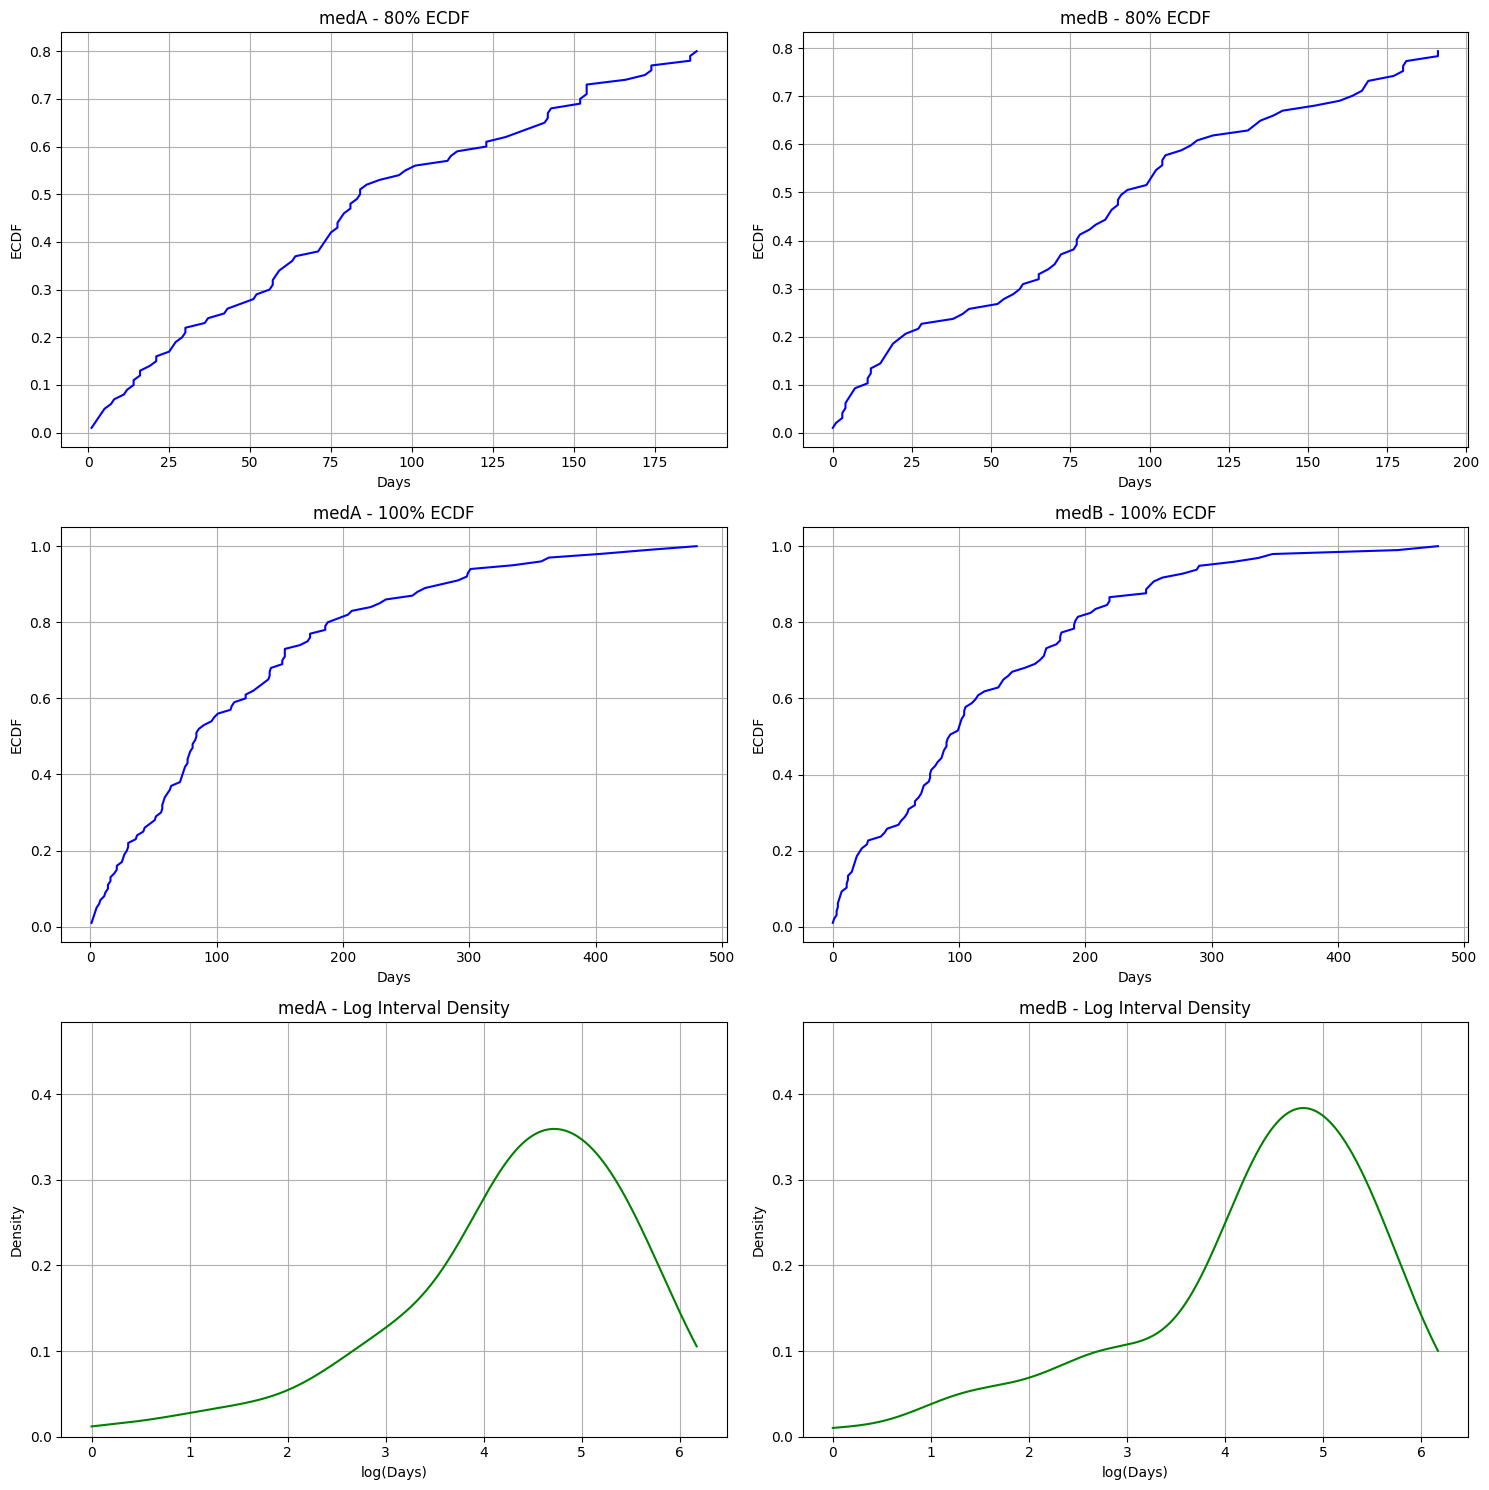

In [154]:
# After generating the data using See()
medA_SEEKmeans = See('medA', tidy)
medB_SEEKmeans = See('medB', tidy)

# Generate visualization
fig = visualization(medA_SEEKmeans, medB_SEEKmeans)
plt.show()